In [7]:
import pandas as pd
import numpy as np
from prophet import Prophet
from datetime import datetime  # 🔹 NEW: to record model run datetime
import os  # for checking file existence

# === Step 1: Load data ===
file_path = "C:/GitHub/Machine-Learning/data/BCM_DATA.csv"
df = pd.read_csv(file_path, parse_dates=["ACC_MONTH"])
df = df.sort_values("ACC_MONTH")

# Prepare columns
df['ds'] = df['ACC_MONTH']
df['y'] = df['TOT_PAID']
regressors = ['BUDGET_AMT', 'NBR_MURDER']
forecast_horizon = 18


# === Step 2: Forecast each regressor normally ===
regressor_forecasts = {}

for reg in regressors:
    reg_df = df[['ds', reg]].rename(columns={reg: 'y'}).copy()

    # Fit Prophet on historical data
    reg_model = Prophet(yearly_seasonality=True)
    reg_model.fit(reg_df)

    total_needed = forecast_horizon + 3
    reg_future = reg_model.make_future_dataframe(periods=total_needed, freq='ME')
    reg_forecast = reg_model.predict(reg_future)
    reg_forecast = reg_forecast[['ds', 'yhat']].rename(columns={'yhat': reg})

    # Apply change rate only to future values
    last_date = df['ds'].max()
    forecast_start = last_date + pd.offsets.MonthEnd(1)
    future_mask = reg_forecast['ds'] >= forecast_start

    
    regressor_forecasts[reg] = reg_forecast

    # # === Plot regressor trend ===
    # plt.figure(figsize=(10, 4))
    # plt.plot(reg_df['ds'], reg_df['y'], label=f'Historical {reg}', linewidth=2)
    # plt.plot(reg_forecast['ds'], reg_forecast[reg], '--', label=f'Forecasted {reg}', linewidth=2)
    # plt.axvline(x=last_date, color='red', linestyle='--', label='Forecast Start')
    # plt.title(f"{reg} - Forecasted with Future Change Rate")
    # plt.xlabel("Date")
    # plt.ylabel(reg)
    # plt.legend()
    # plt.grid(True)
    # plt.tight_layout()
    # plt.show()

# === Step 3: Merge full regressor forecasts ===
full_df = df[['ds', 'y']].copy()
for reg in regressors:
    full_df = full_df.merge(regressor_forecasts[reg], on='ds', how='outer')

# Fill missing and sort
full_df = full_df.sort_values('ds')
full_df[regressors] = full_df[regressors].ffill()

# === Step 4: Train Prophet model on TOT_PAID and record datetime ===
model_run_datetime = datetime.now().strftime("%Y-%m-%d %H:%M:%S")  # 🔹 capture datetime as string

train_df = full_df[full_df['y'].notnull()].dropna(subset=regressors).copy()
model = Prophet(yearly_seasonality=True)
for reg in regressors:
    model.add_regressor(reg)
model.fit(train_df)

# === Step 5: Generate predictions ===
in_sample = model.predict(train_df[["ds"] + regressors])
in_sample['source'] = 'Fitted'




# Create future_df: only rows beyond the last date in original data
future_df = full_df[full_df['ds'] > df['ds'].max()].copy()
future_df = future_df[["ds"] + regressors]

forecast = model.predict(future_df)
forecast['source'] = 'Forecast'

# === Step 6: Save plot-ready forecast data ===
plot_data = pd.DataFrame({'ds': full_df['ds']})
plot_data = plot_data.merge(df[['ds', 'TOT_PAID']].rename(columns={'TOT_PAID': 'Actual_TOT_PAID'}), on='ds', how='left')

plot_preds = pd.concat([in_sample[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'source']],
                        forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'source']]])
plot_preds = plot_preds.rename(columns={
    'yhat': 'Prediction_TOT_PAID',
    'yhat_lower': 'Prediction_TOT_PAID_lower',
    'yhat_upper': 'Prediction_TOT_PAID_upper'
})
plot_data = plot_data.merge(plot_preds, on='ds', how='left')

for reg in regressors:
    actual_reg = df[['ds', reg]].rename(columns={reg: f'Actual_{reg}'})
    forecasted_reg = regressor_forecasts[reg][['ds', reg]].rename(columns={reg: f'Forecast_{reg}'})
    plot_data = plot_data.merge(actual_reg, on='ds', how='left')
    plot_data = plot_data.merge(forecasted_reg, on='ds', how='left')

# 🔹 Add model run datetime as a new column
plot_data['model_run_datetime'] = model_run_datetime

# # Save to CSV
# plot_data = plot_data.sort_values('ds')
# plot_ready_path = "C:/GitHub/Machine-Learning/data/Plot_Ready_Forecast_Data.csv"
# plot_data.to_csv(plot_ready_path, index=False)
# print(f"\n📁 Plot-ready dataset saved to: {plot_ready_path}")
# print(f"📅 Model run datetime: {model_run_datetime}")



# === Step 7: Load the CSV file ===
file_path = r"C:\GitHub\Machine-Learning\data\Plot_Ready_Forecast_Data.csv"
df = pd.read_csv(file_path, parse_dates=['ds'])
latest_model_run = df['model_run_datetime'].max()
latest_df = df[df['model_run_datetime'] == latest_model_run].copy()
print(f"✅ Filtered {len(latest_df)} rows from the latest model run: {latest_model_run}")
#print(latest_df.tail())

# === Step 8: Calculate MAPE and conditionally append ===
# === Step 8: Calculate MAPE between forecasted values in plot_data and latest_df ===

def calculate_mape(actual, predicted):
    """Calculate Mean Absolute Percentage Error"""
    mask = (actual != 0) & (~actual.isna()) & (~predicted.isna())
    return np.mean(np.abs((actual[mask] - predicted[mask]) / actual[mask])) * 100

# Filter both dataframes to only include forecasted values
forecast_plot_data = plot_data[plot_data['source'] == 'Forecast'][['ds', 'Prediction_TOT_PAID']].rename(
    columns={'Prediction_TOT_PAID': 'plot_pred'})
forecast_latest_df = latest_df[latest_df['source'] == 'Forecast'][['ds', 'Prediction_TOT_PAID']].rename(
    columns={'Prediction_TOT_PAID': 'latest_pred'})

# Merge on 'ds' to compare corresponding forecasted predictions
merged_forecast = pd.merge(forecast_plot_data, forecast_latest_df, on='ds', how='inner')

# Calculate MAPE between the two sets of forecasted predictions
mape = calculate_mape(merged_forecast['latest_pred'], merged_forecast['plot_pred'])

print(f"\n📊 MAPE between current and latest forecasted TOT_PAID: {mape:.2f}%")

if mape >= 5:
    # Append current plot_data to existing dataset
    full_path = r"C:\GitHub\Machine-Learning\data\Plot_Ready_Forecast_Data.csv"
    
    # Load old data
    old_df = pd.read_csv(full_path, parse_dates=['ds'])
    
    # Append new forecast
    combined_df = pd.concat([old_df, plot_data], ignore_index=True)
    combined_df.to_csv(full_path, index=False)

    print(f"📁 MAPE ≥ 5%. New forecast data appended to {full_path}")
else:
    print("✅ MAPE < 5%. Forecast is similar to the latest run. No update made.")


12:08:51 - cmdstanpy - INFO - Chain [1] start processing
12:08:51 - cmdstanpy - INFO - Chain [1] done processing
12:08:51 - cmdstanpy - INFO - Chain [1] start processing
12:08:51 - cmdstanpy - INFO - Chain [1] done processing
12:08:51 - cmdstanpy - INFO - Chain [1] start processing
12:08:51 - cmdstanpy - INFO - Chain [1] done processing


✅ Filtered 188 rows from the latest model run: 3/23/2025 12:03

📊 MAPE between current and latest forecasted TOT_PAID: 9502.46%
📁 MAPE ≥ 5%. New forecast data appended to C:\GitHub\Machine-Learning\data\Plot_Ready_Forecast_Data.csv


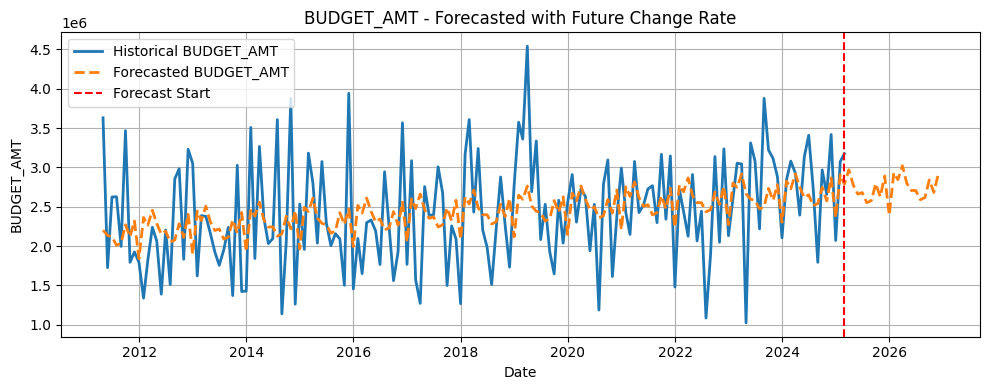

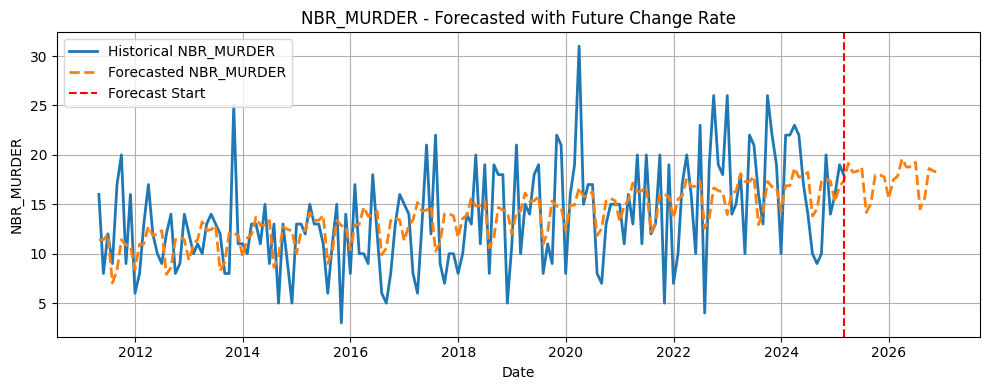

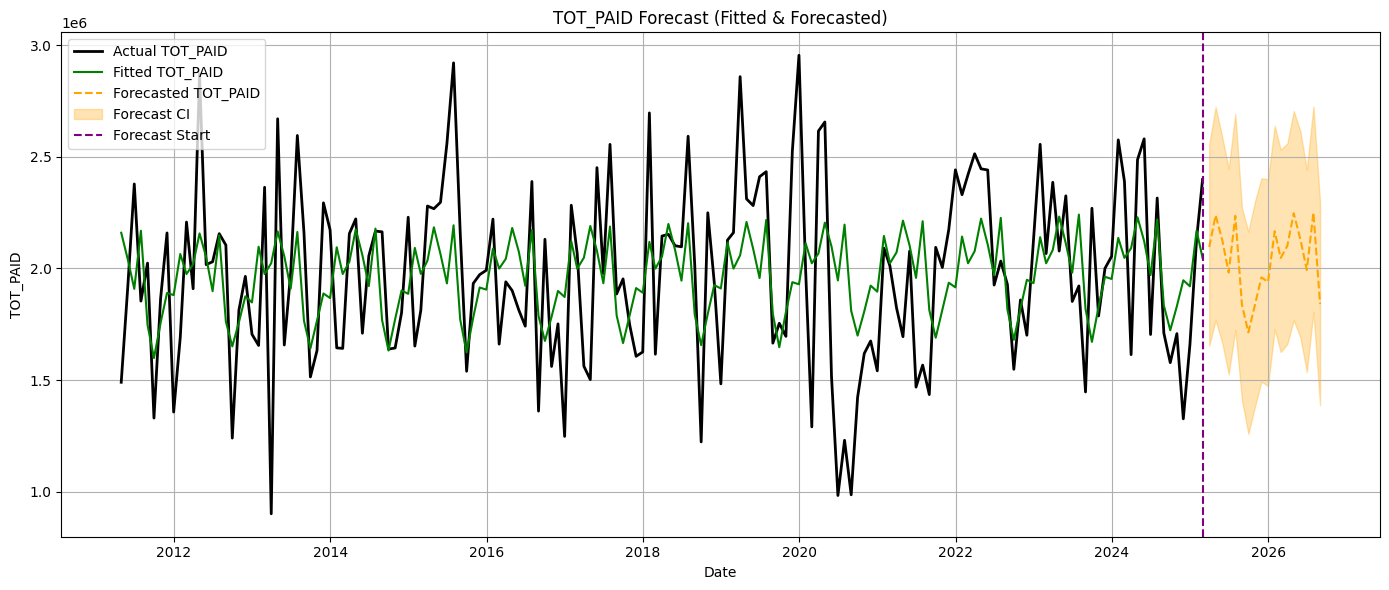

In [26]:
# === Step 11: Recreate plots from saved plot-ready dataset ===

import pandas as pd
import matplotlib.pyplot as plt

# Load saved dataset
plot_data_path = "C:/GitHub/Machine-Learning/data/Plot_Ready_Forecast_Data.csv"
plot_df = pd.read_csv(plot_data_path, parse_dates=["ds"])

# Get last date of actuals to mark forecast start
last_actual_date = plot_df[plot_df['Actual_TOT_PAID'].notnull()]['ds'].max()

# === Plot Regressor Forecasts ===
regressors = ['BUDGET_AMT', 'NBR_MURDER']

for reg in regressors:
    plt.figure(figsize=(10, 4))
    plt.plot(plot_df['ds'], plot_df[f'Actual_{reg}'], label=f'Historical {reg}', linewidth=2)
    plt.plot(plot_df['ds'], plot_df[f'Forecast_{reg}'], '--', label=f'Forecasted {reg}', linewidth=2)
    plt.axvline(x=last_actual_date, color='red', linestyle='--', label='Forecast Start')
    plt.title(f"{reg} - Forecasted with Future Change Rate")
    plt.xlabel("Date")
    plt.ylabel(reg)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# === Plot TOT_PAID Forecast (Fitted + Forecasted) ===
plt.figure(figsize=(14, 6))
plt.plot(plot_df['ds'], plot_df['Actual_TOT_PAID'], label='Actual TOT_PAID', color='black', linewidth=2)

# Split fitted and forecasted data
fitted_df = plot_df[plot_df['source'] == 'Fitted']
forecast_df = plot_df[plot_df['source'] == 'Forecast']

plt.plot(fitted_df['ds'], fitted_df['Prediction_TOT_PAID'], label='Fitted TOT_PAID', color='green')
plt.plot(forecast_df['ds'], forecast_df['Prediction_TOT_PAID'], '--', label='Forecasted TOT_PAID', color='orange')

# Confidence interval for forecast
plt.fill_between(forecast_df['ds'],
                 forecast_df['Prediction_TOT_PAID_lower'],
                 forecast_df['Prediction_TOT_PAID_upper'],
                 color='orange', alpha=0.3, label='Forecast CI')

plt.axvline(x=last_actual_date, color='purple', linestyle='--', label='Forecast Start')
plt.title("TOT_PAID Forecast (Fitted & Forecasted)")
plt.xlabel("Date")
plt.ylabel("TOT_PAID")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [57]:
import os
import pandas as pd
import numpy as np
from prophet import Prophet
from datetime import datetime

# === Step 1: Load data ===
file_path = "C:/GitHub/Machine-Learning/data/BCM_DATA.csv"
df = pd.read_csv(file_path, parse_dates=["ACC_MONTH"])
df = df.sort_values("ACC_MONTH")

# Prepare columns
df['ds'] = df['ACC_MONTH']
df['y'] = df['TOT_PAID']
regressors = ['BUDGET_AMT', 'NBR_MURDER']
forecast_horizon = 18

# === Step 2: Forecast each regressor ===
regressor_forecasts = {}
last_date = df['ds'].max()
forecast_start = last_date + pd.offsets.MonthEnd(1)

for reg in regressors:
    reg_df = df[['ds', reg]].rename(columns={reg: 'y'})
    reg_model = Prophet(yearly_seasonality=True)
    reg_model.fit(reg_df)
    future = reg_model.make_future_dataframe(periods=forecast_horizon + 3, freq='ME')
    forecasted = reg_model.predict(future)[['ds', 'yhat']].rename(columns={'yhat': reg})
    regressor_forecasts[reg] = forecasted

# === Step 3: Merge regressor forecasts ===
full_df = df[['ds', 'y']]
for reg in regressors:
    full_df = full_df.merge(regressor_forecasts[reg], on='ds', how='outer')
full_df = full_df.sort_values('ds')
full_df[regressors] = full_df[regressors].ffill()

# === Step 4: Prepare future regressor values ===
future_dates = pd.date_range(start=forecast_start, periods=forecast_horizon, freq='ME')
future_df = pd.DataFrame({'ds': future_dates})
for reg in regressors:
    future_df = future_df.merge(regressor_forecasts[reg], on='ds', how='left')
future_df = future_df.dropna(subset=regressors)

# === Step 5: Train Prophet model ===
model_run_datetime = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
train_df = full_df[full_df['y'].notnull()].dropna(subset=regressors)
model = Prophet(yearly_seasonality=True)
for reg in regressors:
    model.add_regressor(reg)
model.fit(train_df)

# === Step 6: Generate predictions ===
in_sample = model.predict(train_df[["ds"] + regressors])
in_sample['source'] = 'Fitted'

forecast = model.predict(future_df)
forecast['source'] = 'Forecast'

# === Step 7: Create plot-ready dataset ===
plot_data = pd.DataFrame({'ds': full_df['ds']})
plot_data = plot_data.merge(df[['ds', 'TOT_PAID']].rename(columns={'TOT_PAID': 'Actual_TOT_PAID'}), on='ds', how='left')

plot_preds = pd.concat([
    in_sample[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'source']],
    forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'source']]
])
plot_preds = plot_preds.rename(columns={
    'yhat': 'Prediction_TOT_PAID',
    'yhat_lower': 'Prediction_TOT_PAID_lower',
    'yhat_upper': 'Prediction_TOT_PAID_upper'
})
plot_data = plot_data.merge(plot_preds, on='ds', how='left')

for reg in regressors:
    actual = df[['ds', reg]].rename(columns={reg: f'Actual_{reg}'})
    forecasted = regressor_forecasts[reg][['ds', reg]].rename(columns={reg: f'Forecast_{reg}'})
    plot_data = plot_data.merge(actual, on='ds', how='left')
    plot_data = plot_data.merge(forecasted, on='ds', how='left')

plot_data['model_run_datetime'] = model_run_datetime
plot_data = plot_data.sort_values('ds')

# === Step 8: Compare to most recent forecast using MAPE ===
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    if mask.sum() == 0:
        return np.inf
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

append_new_data = True
plot_ready_path = "C:/GitHub/Machine-Learning/data/Plot_Ready_Forecast_Data.csv"

if os.path.exists(plot_ready_path):
    prev_data = pd.read_csv(plot_ready_path, parse_dates=["ds", "model_run_datetime"])
    forecast_rows = prev_data[prev_data['source'] == 'Forecast'].copy()
    forecast_rows['model_run_datetime'] = pd.to_datetime(forecast_rows['model_run_datetime'], errors='coerce')

    forecast_rows = forecast_rows.sort_values('model_run_datetime', ascending=False)
    most_recent_run = forecast_rows['model_run_datetime'].iloc[0]
    prev_forecast = forecast_rows[forecast_rows['model_run_datetime'] == most_recent_run][['ds', 'Prediction_TOT_PAID']]

    current_forecast = forecast[['ds', 'yhat']].rename(columns={'yhat': 'Prediction_TOT_PAID'})
    prev_forecast['ds'] = pd.to_datetime(prev_forecast['ds'])
    current_forecast['ds'] = pd.to_datetime(current_forecast['ds'])
    merged = pd.merge(prev_forecast, current_forecast, on='ds', suffixes=('_old', '_new'))

    if not merged.empty:
        mape = mean_absolute_percentage_error(
            merged['Prediction_TOT_PAID_old'], merged['Prediction_TOT_PAID_new']
        )
        print(f"\U0001F4CA MAPE compared to most recent forecast run: {mape:.2f}%")

        if mape <= 5:
            append_new_data = False
            print("✅ New forecast is not significantly different. Skipping append.")
        else:
            print("⚠️ Forecast has changed significantly. Appending new forecast...")

# === Step 9: Save or append plot_data ===
if append_new_data:
    if os.path.exists(plot_ready_path):
        plot_data.to_csv(plot_ready_path, mode='a', header=False, index=False)
        print(f"\n📁 New forecast data appended to: {plot_ready_path}")
    else:
        plot_data.to_csv(plot_ready_path, index=False)
        print(f"\n📁 New forecast data saved to: {plot_ready_path}")

# === Step 10: Save the most recent and current forecast to separate files ===
latest_forecast_output_path = "C:/GitHub/Machine-Learning/data/Latest_Forecast_Run.csv"
current_forecast_output_path = "C:/GitHub/Machine-Learning/data/Current_Model_Forecast.csv"

if os.path.exists(plot_ready_path):
    prev_data = pd.read_csv(plot_ready_path, parse_dates=["ds", "model_run_datetime"])
    forecast_rows = prev_data[prev_data['source'] == 'Forecast'].copy()
    forecast_rows['model_run_datetime'] = pd.to_datetime(forecast_rows['model_run_datetime'], errors='coerce')
    forecast_rows = forecast_rows.sort_values('model_run_datetime', ascending=False)
    most_recent_run = forecast_rows['model_run_datetime'].iloc[0]
    most_recent_forecast = forecast_rows[forecast_rows['model_run_datetime'] == most_recent_run]

    most_recent_forecast.to_csv(latest_forecast_output_path, index=False)
    print(f"📁 Most recent forecast run saved to: {latest_forecast_output_path}")
    print(f"🕒 model_run_datetime used for most recent forecast: {most_recent_run}")

plot_data.to_csv(current_forecast_output_path, index=False)
print(f"📁 Current model forecast saved to: {current_forecast_output_path}")
print(f"🕒 model_run_datetime used for current run: {model_run_datetime}")


17:57:07 - cmdstanpy - INFO - Chain [1] start processing
17:57:07 - cmdstanpy - INFO - Chain [1] done processing
17:57:08 - cmdstanpy - INFO - Chain [1] start processing
17:57:08 - cmdstanpy - INFO - Chain [1] done processing
17:57:08 - cmdstanpy - INFO - Chain [1] start processing
17:57:08 - cmdstanpy - INFO - Chain [1] done processing


📊 MAPE compared to most recent forecast run: 976720.16%
⚠️ Forecast has changed significantly. Appending new forecast...

📁 New forecast data appended to: C:/GitHub/Machine-Learning/data/Plot_Ready_Forecast_Data.csv
📁 Most recent forecast run saved to: C:/GitHub/Machine-Learning/data/Latest_Forecast_Run.csv
🕒 model_run_datetime used for most recent forecast: 2025-03-22 16:08:00
📁 Current model forecast saved to: C:/GitHub/Machine-Learning/data/Current_Model_Forecast.csv
🕒 model_run_datetime used for current run: 2025-03-22 17:57:08


In [ ]:
import pandas as pd

# === Step 1: Load the file ===
file_path = "C:/GitHub/Machine-Learning/data/Current_Model_Forecast.csv"
df = pd.read_csv(file_path)

# === Step 2: Convert 'model_run_datetime' column to datetime ===
df['model_run_datetime'] = pd.to_datetime(df['model_run_datetime'], errors='coerce')
max_datetime = df['model_run_datetime'].max()
# === Step 3: Get the most recent datetime ===


# === Step 4: Print the result ===
print("🕒 Most recent model_run_datetime:", max_datetime)

🕒 Most recent model_run_datetime: 2025-03-22 17:32:49
